In [1]:
# Tang Kit Lim (WQD190032)

import numpy as np 
import pandas as pd
import datetime
from pathlib import Path
from geopy.distance import distance

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

processed_transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'
# transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

transactions = pd.read_csv(processed_transaction_csv, na_values=['None'], index_col=0)


## Data preparation for Model Training 

In [3]:
transactions = transactions[transactions['year'] >= 2017]

transactions['non_landed'] = transactions['non_landed'].astype('category')
transactions['project_id'] = transactions['project_id'].astype('category')

In [4]:
transactions[transactions['project_id'] == 15292]

,project_id,township,property_type,tenure,area_sqft,non_landed,bedrooms,psf,price,planning_region,...,poi_nearby_education,poi_nearby_transportation,poi_nearby_healthcare,nearest_school,nearest_train_station,nearest_hospital,total_poi_nearby,nearest_poi,transaction_count,year
192639,15292,The Z Residence,Condominium/Apartment,Freehold,1238.0,1,3.0,573.505654,710000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2017
192640,15292,The Z Residence,Condominium/Apartment,Freehold,1410.0,1,3.0,517.730496,730000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2017
192641,15292,The Z Residence,Condominium/Apartment,Freehold,1249.0,1,3.0,510.808647,638000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2017
192642,15292,The Z Residence,Condominium/Apartment,Freehold,1238.0,1,3.0,521.001616,645000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2017
192643,15292,The Z Residence,Condominium/Apartment,Freehold,1399.0,1,3.0,557.541101,780000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192779,15292,The Z Residence,Condominium/Apartment,Leasehold,1238.0,1,3.0,456.381260,565000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2019
192780,15292,The Z Residence,Condominium/Apartment,Freehold,1238.0,1,3.0,508.885299,630000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2019
192781,15292,The Z Residence,Condominium/Apartment,Leasehold,1410.0,1,3.0,460.992908,650000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2019
192782,15292,The Z Residence,Condominium/Apartment,Freehold,1410.0,1,3.0,470.212766,663000,Bukit Jalil,...,31,7,1,74.808759,292.098721,3882.505107,39,74.808759,145,2019


In [5]:
transactions.isna().sum()

project_id                     0
township                       0
property_type                  0
tenure                         0
area_sqft                      0
non_landed                     0
bedrooms                       0
psf                            0
price                          0
planning_region              474
township.1                     0
state                          0
city                          24
median_psf                     0
median_price                   0
poi_nearby_education           0
poi_nearby_transportation      0
poi_nearby_healthcare          0
nearest_school                 0
nearest_train_station          0
nearest_hospital               0
total_poi_nearby               0
nearest_poi                    0
transaction_count              0
year                           0
dtype: int64

In [6]:
transactions.dropna(inplace = True)

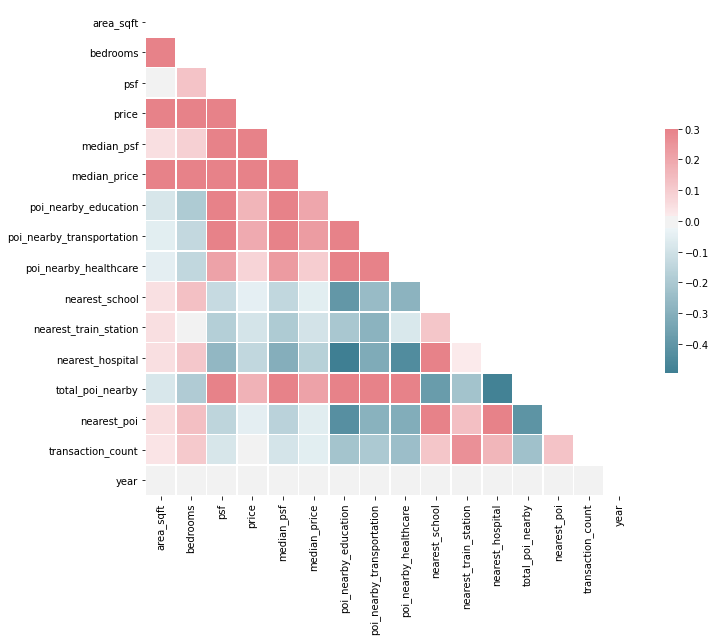

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Selections (Repeating)

In [8]:
# after rounds of evaluating the models, drop features with collinearity
# although including all features achieved highest accuracy predicting the testing set
# but advantages are not marginal and those informtion is hard for user input
numerical_features = [
    'area_sqft', 'bedrooms', 'nearest_poi'
    # 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare',
    # 'nearest_school', 'nearest_train_station', 'nearest_hospital', 'total_poi_nearby',
]

categorical_features = [
    'city', 'project_id', 'property_type', 'tenure', 'state' #, 'non_landed', 'planning_region'
]

features = numerical_features + categorical_features
target = 'price'

transactions = transactions[features + [target]]

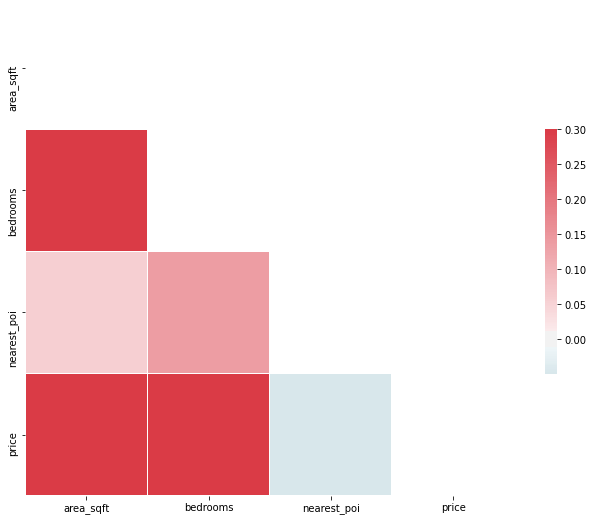

In [9]:
# correlation heatmap for the selected (numerical) features only
corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model Training & Evaluation (Repeating)

In [10]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [11]:
x = transactions[features]
y = transactions[target]

column_transform = make_column_transformer(
    (MinMaxScaler(), numerical_features),
    (OneHotEncoder(), categorical_features),
    remainder='passthrough'
)

column_transform.fit_transform(x)

preprocess = make_pipeline(
    column_transform
)
preprocess.fit_transform(x)

linear_regression = LinearRegression()


In [12]:
pipeline = make_pipeline(preprocess, linear_regression)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 17)

In [14]:
pipeline.fit(x, y)
print("Score: %f" % pipeline.score(x_test, y_test))

pd.DataFrame({
    'predicted_price': y_test,
    'price': pipeline.predict(x_test)
})

Score: 0.837008


,predicted_price,price
116120,408000,3.716109e+05
106097,990400,1.159037e+06
136085,328000,3.232252e+05
16063,308000,3.586679e+05
148029,1485000,1.184312e+06
...,...,...
16231,420000,4.085870e+05
106610,788000,7.649103e+05
55342,270000,2.475857e+05
32320,1475000,1.912183e+06


In [15]:
from pickle import dump
dump(pipeline, open('../data/model.pkl', 'wb'))


In [16]:
x_test

,area_sqft,bedrooms,nearest_poi,city,project_id,property_type,tenure,state
116120,958.0,3.0,253.888056,Batu Caves,8900,Condominium/Apartment,Leasehold,Selangor
106097,5038.0,4.0,587.027386,Sungai Buloh,11251,Semi-Detached House,Leasehold,Selangor
136085,743.0,3.0,293.300022,USJ,9752,Condominium/Apartment,Freehold,Selangor
16063,1044.0,3.0,771.331442,Kuchai Lama,9026,Condominium/Apartment,Leasehold,Kuala Lumpur
148029,1862.0,3.0,163.395514,Bukit Jalil,10162,Condominium/Apartment,Freehold,Kuala Lumpur
...,...,...,...,...,...,...,...,...
16231,1141.0,3.0,479.564803,Bandar Baru Sri Petaling,9619,Condominium/Apartment,Freehold,Kuala Lumpur
106610,1765.0,4.0,1857.991111,Kajang,15063,Terrace House,Freehold,Selangor
55342,958.0,3.0,887.809343,Pasir Gudang,12862,Terrace House,Freehold,Johor
32320,6297.0,3.0,366.756171,Petaling Jaya,11396,Detached House,Leasehold,Selangor
